# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.208719,False,1.891938
1,-1.147622,True,2.486369
2,-0.108037,True,2.756183
3,-0.137112,True,6.292265
4,-3.177042,False,-7.992284
...,...,...,...
995,-2.607299,True,-2.514279
996,0.337554,False,1.846308
997,-1.147474,True,3.927873
998,-1.081519,False,-2.581914


<AxesSubplot:xlabel='v0'>

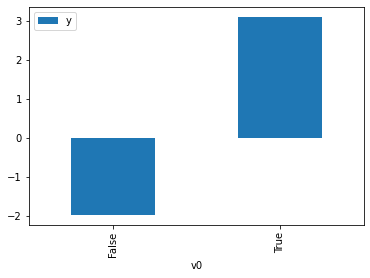

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

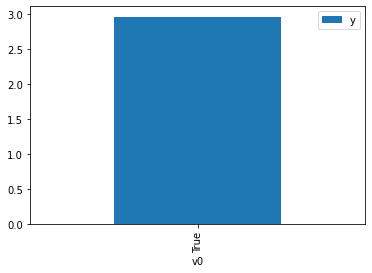

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.563751,False,1.504854,0.431427,2.317891
1,0.634255,False,1.174328,0.424974,2.353087
2,-0.497257,False,-1.424488,0.530114,1.886386
3,0.659123,False,2.625052,0.422703,2.365725
4,-0.884390,False,-1.979470,0.565944,1.766958
...,...,...,...,...,...
995,-0.772886,False,-2.469237,0.555678,1.799603
996,-1.018761,False,-2.455540,0.578241,1.729384
997,-0.443588,False,-1.496007,0.525114,1.904350
998,0.827226,False,1.431407,0.407448,2.454303


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.446439,True,-1.473736,0.299588,3.337918
1,-0.573989,True,5.071731,0.462748,2.161006
2,-0.440078,True,4.410054,0.475214,2.104317
3,-2.892499,True,-3.171898,0.265805,3.762154
4,-0.536212,True,3.070451,0.466260,2.144725
...,...,...,...,...,...
995,-0.602445,True,4.453360,0.460104,2.173422
996,-1.782701,True,0.451006,0.354084,2.824192
997,-1.635257,True,-0.587289,0.366789,2.726365
998,-1.629622,True,1.179624,0.367278,2.722733


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              6815.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:29:01   Log-Likelihood:                         -1432.6
No. Observations:                1000   AIC:                                      2869.
Df Residuals:                     998   BIC:                                      2879.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4038      0.026     90.832      0.000       2.352       2.456
x2             5.0001      0.051     98.359      0.000       4.900       5.100
==============================================================================
Omnibus:                        5.354   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.247
Skew:                           0.174   Prob(JB):                       0.0725
Kurtosis:                       3.072   Cond. No.                         2.10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""